In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

In [2]:
all_data=pd.read_csv("OMX_Nordic_40.csv")
all_data["Date"]=pd.to_datetime(all_data["Date"],format="%Y-%m-%d")
display(all_data)
# plt.plot(all_data["Date"],all_data["High price"])
# plt.plot(all_data["Date"],all_data["Low price"])
# plt.plot(all_data["Date"],all_data["Closing price"])
# plt.show()

,Date,High price,Low price,Closing price
0,2001-12-28,NaN,NaN,1000.00
1,2002-01-02,NaN,NaN,983.52
2,2002-01-03,NaN,NaN,1024.30
3,2002-01-04,NaN,NaN,1025.50
4,2002-01-07,NaN,NaN,1020.14
...,...,...,...,...
5679,2024-04-04,2760.12,2739.26,2747.39
5680,2024-04-05,2739.58,2712.48,2738.46
5681,2024-04-08,2764.17,2736.28,2757.69
5682,2024-04-09,2762.93,2735.93,2739.41


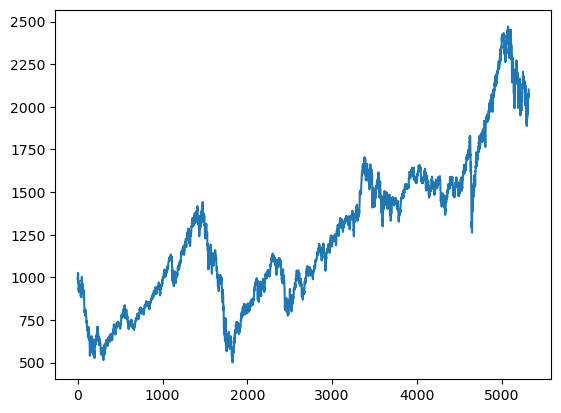

In [3]:
validation_data = all_data["Closing price"].tail(365)
data = all_data["Closing price"].head(-365)
plt.plot(data)
plt.show()

In [4]:
#We notice a few wrong values (fixable), and two series starts only from 2007
#We notice 2008 global crisis and 2020 Covid-19 pandemic. When crisis it is hard to predict... Maybe we should consider only stable periods (i.e. after 2009)? Or maybe go to a more stable scale such as log?

In [5]:
# #Zooming in looking for periodicty
# first_samples=data.head(2000)
# plt.plot(first_samples["Date"],first_samples["Closing price"])
# plt.show()

## Cleaning the data

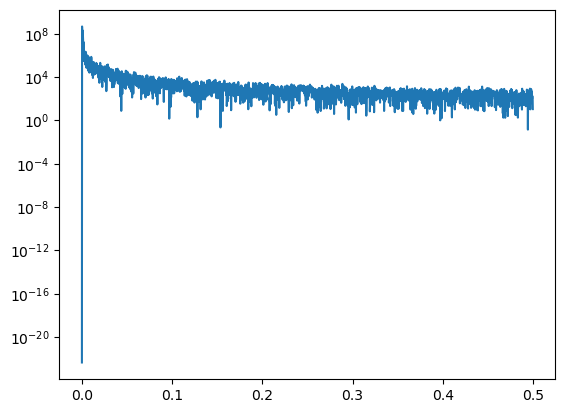

Peaks at 0.00018800526414739614 with power 466942006.292797


In [6]:
from scipy.signal import periodogram
f, Pxx = periodogram(data)
plt.plot(f,Pxx)
plt.yscale("log")
plt.show()
peaks = np.argmax(Pxx)
print(f"Peaks at {f[peaks]} with power {Pxx[peaks]}")

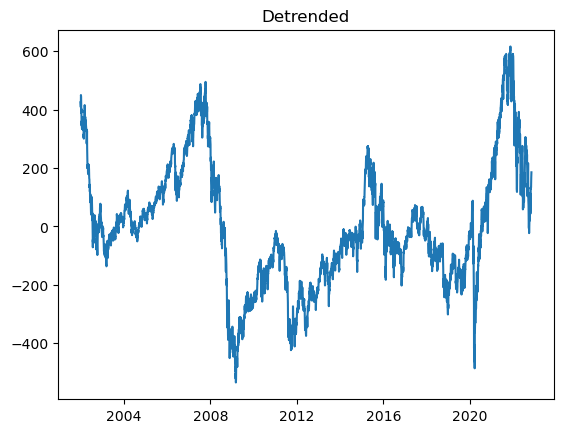

In [7]:
from statsmodels.tsa.tsatools import detrend
detrended = detrend(data)

# from statsmodels.tsa.seasonal import STL

# res = stl.fit()
# detrended = res.trend

plt.plot(all_data["Date"].head(-365), detrended)
plt.title("Detrended")
plt.show()

In [8]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(detrended)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.753357
p-value: 0.065251
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [9]:
# KPSS test
from statsmodels.tsa.stattools import kpss
result = kpss(detrended)
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[3].items():
    print('\t%s: %.3f' % (key, value))


KPSS Statistic: 1.028746
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2080\4109265067.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(detrended)


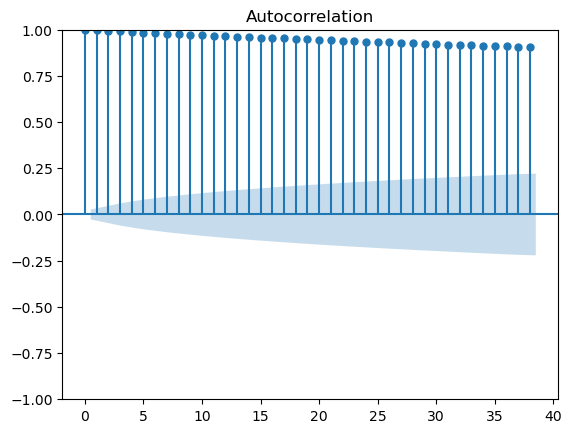

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(detrended)
plt.show()

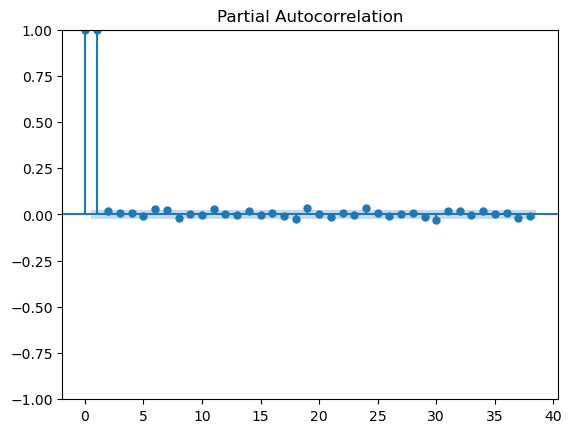

In [11]:
plot_pacf(detrended)
plt.show()

## Differencing

            Closing price diff
Date                          
2002-01-02              -16.48
2002-01-03               40.78
2002-01-04                1.20
2002-01-07               -5.36
2002-01-08              -36.61
2002-01-09               -4.86
2002-01-10              -13.05
2002-01-11               13.82
2002-01-14              -43.49
2002-01-15               -0.63


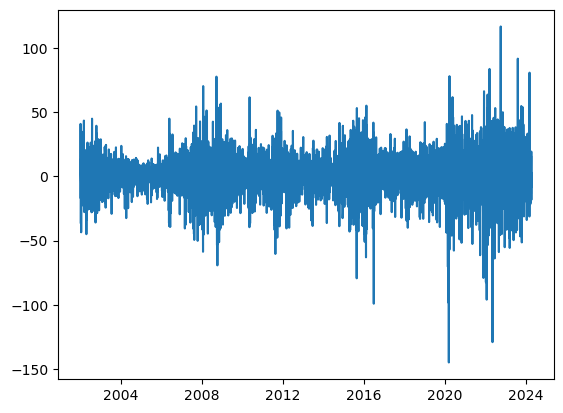

In [12]:
all_data["Closing price diff"] = all_data["Closing price"].diff()

# create a new dataframe with only the closing price diff and date
all_diff_data = all_data[["Date", "Closing price diff"]].dropna()
all_diff_data.set_index("Date", inplace=True)
print(all_diff_data.head(10))

# plot the diff data
plt.plot(all_diff_data)
plt.show()

In [15]:
diff_data = all_diff_data["Closing price diff"].head(-365)

# ADF test
from statsmodels.tsa.stattools import adfuller
result = adfuller(diff_data)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -23.937203
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [16]:
# KPSS test
from statsmodels.tsa.stattools import kpss
result = kpss(diff_data)
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[3].items():
    print('\t%s: %.3f' % (key, value))


KPSS Statistic: 0.122391
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2080\2174026023.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(diff_data)


## Fitting ARMA models